In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

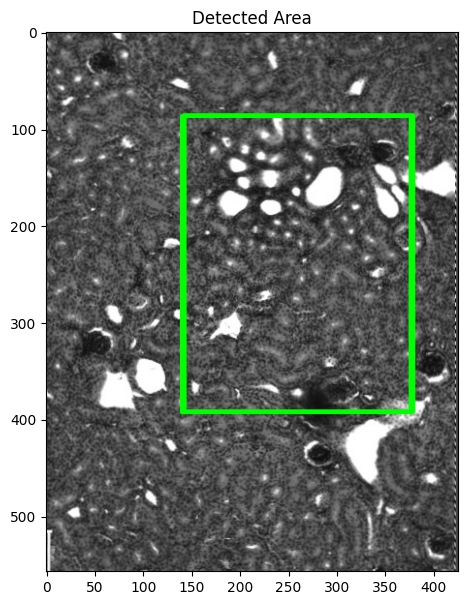

Matching area found at position: 85 141


In [9]:
def find_template(large_image_path, small_image_path):
    # Read the large and small images
    img = cv2.imread(large_image_path, 0)  # Load in grayscale
    template = cv2.imread(small_image_path, 0)  # Load in grayscale

    # Dimensions of the template
    w, h = template.shape[::-1]

    # Perform template matching
    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

    # Threshold for detecting match, can be adjusted based on use-case
    threshold = 0.13
    loc = np.where(res >= threshold)

    # Create a copy of the image to draw on
    img_display = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for pt in zip(*loc[::-1]):  # Switch x and y coordinates
        cv2.rectangle(img_display, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

    # Display the original image with the rectangle around the match
    plt.figure(figsize=(10, 7))
    plt.imshow(img_display)
    plt.title('Detected Area')
    plt.show()

    if len(loc[0]) == 0:
        print("No matching area found.")
    else:
        print("Matching area found at position:", loc[0][0], loc[1][0])

# Example usage
find_template('big.jpg', 'little.jpg')

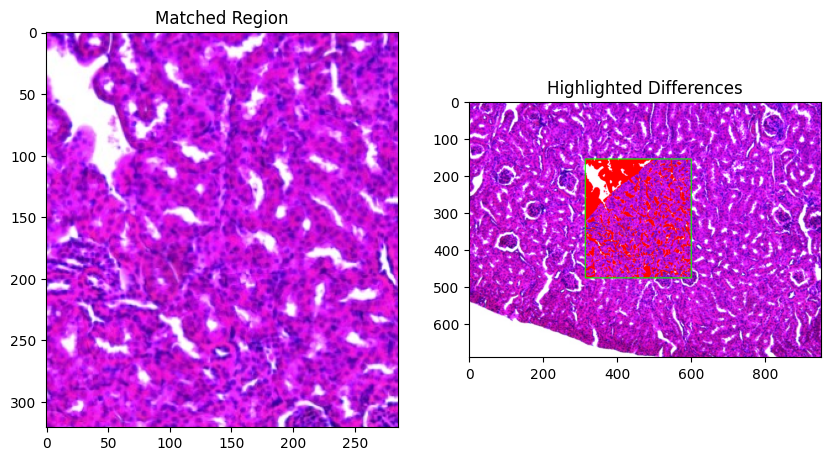

In [17]:
def find_and_compare_template(large_image_path, small_image_path):
    # Read the large and small images
    img = cv2.imread(large_image_path, cv2.IMREAD_COLOR)  # Load in color
    template = cv2.imread(small_image_path, cv2.IMREAD_COLOR)  # Load in color

    # Convert images to grayscale for template matching
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    w, h = template_gray.shape[::-1]

    # Perform template matching
    res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # Use the max location for the best match
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Extract the matching region from the original image
    matched_region = img[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]

    # Create a mask where differences are highlighted
    diff = cv2.absdiff(matched_region, template)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)  # Threshold adjusted based on the sensitivity required

    # Create an output image that highlights differences in red
    img_highlighted = img.copy()
    img_highlighted[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w][mask > 0] = [0, 0, 255]

    # Draw a rectangle around the matched region
    cv2.rectangle(img_highlighted, top_left, bottom_right, (0, 255, 0), 2)

    # Display the results
    plt.figure(figsize=(10, 7))
    plt.subplot(121), plt.imshow(cv2.cvtColor(matched_region, cv2.COLOR_BGR2RGB))
    plt.title('Matched Region')
    plt.subplot(122), plt.imshow(cv2.cvtColor(img_highlighted, cv2.COLOR_BGR2RGB))
    plt.title('Highlighted Differences')
    plt.show()
find_and_compare_template('big.jpg', 'little.jpg')

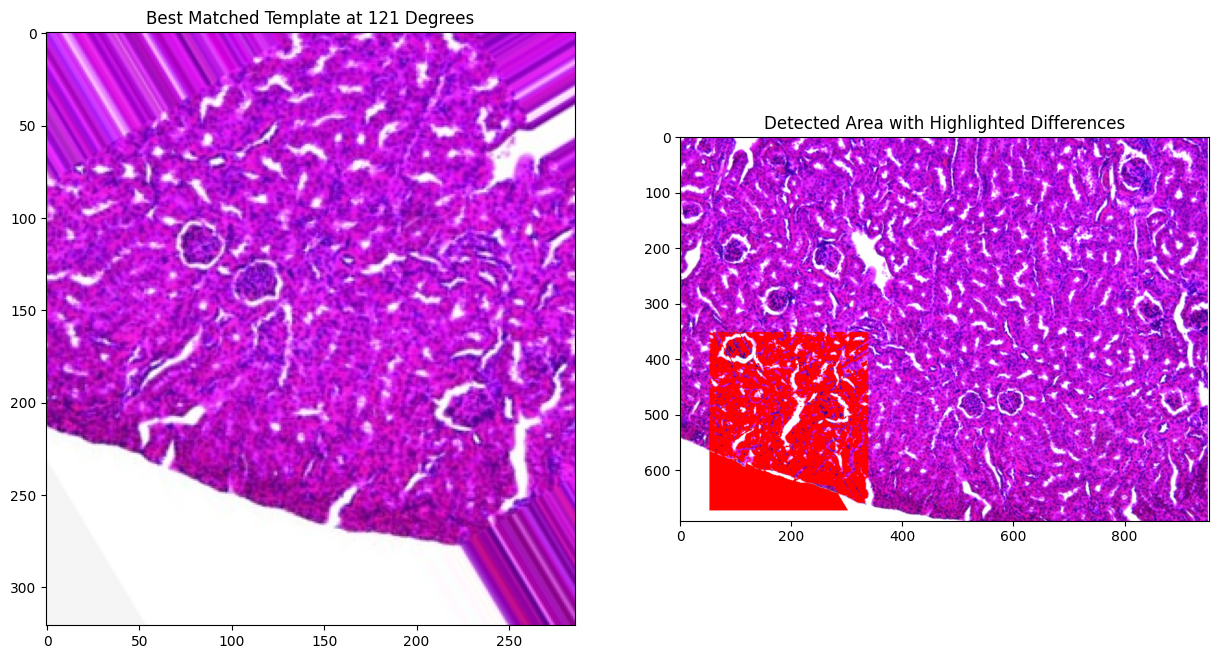

In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def find_template_with_rotation_and_highlight(large_image_path, small_image_path):
    img = cv2.imread(large_image_path, cv2.IMREAD_COLOR)
    template_orig = cv2.imread(small_image_path, cv2.IMREAD_COLOR)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Try different angles
    best_score = -1
    best_angle = 0
    best_loc = None
    best_match = None
    for angle in range(0, 360, 1):  # Adjust step for finer/coarser search
        template = rotate_image(template_orig, angle)
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_angle = angle
            best_loc = max_loc
            best_match = template.copy()

    # Extract best matching region
    top_left = best_loc
    h, w = best_match.shape[:2]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    matched_region = img[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]

    # Calculate differences and create mask
    diff = cv2.absdiff(matched_region, best_match)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY_INV)  # Sensitivity adjustment needed

    # Highlight differences in red
    img_highlighted = img.copy()
    img_highlighted[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w][mask > 0] = [0, 0, 255]

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.subplot(121), plt.imshow(cv2.cvtColor(best_match, cv2.COLOR_BGR2RGB))
    plt.title('Best Matched Template at ' + str(best_angle) + ' Degrees')
    plt.subplot(122), plt.imshow(cv2.cvtColor(img_highlighted, cv2.COLOR_BGR2RGB))
    plt.title('Detected Area with Highlighted Differences')
    plt.show()

# Example usage
find_template_with_rotation_and_highlight('big.jpg', 'little.jpg')

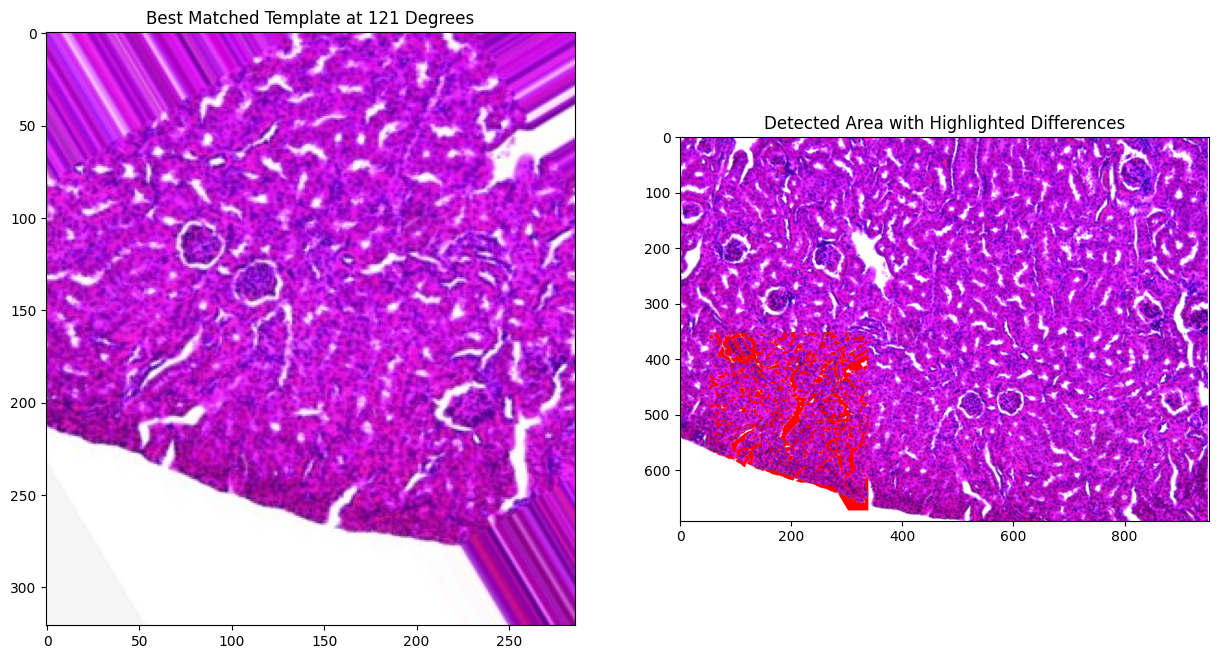

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def find_template_with_rotation_and_color_highlight(large_image_path, small_image_path):
    img = cv2.imread(large_image_path, cv2.IMREAD_COLOR)
    template_orig = cv2.imread(small_image_path, cv2.IMREAD_COLOR)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Try different angles
    best_score = -1
    best_angle = 0
    best_loc = None
    best_match = None
    for angle in range(0, 360, 1):  # Adjust step for finer/coarser search
        template = rotate_image(template_orig, angle)
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_angle = angle
            best_loc = max_loc
            best_match = template.copy()

    # Extract best matching region
    top_left = best_loc
    h, w = best_match.shape[:2]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    matched_region = img[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]

    # Calculate differences and create mask
    diff = cv2.absdiff(matched_region, best_match)
    _, mask = cv2.threshold(cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY), 50, 255, cv2.THRESH_BINARY)  # Sensitivity adjustment needed

    # Apply mask to highlight differences in red on the original image
    img_highlighted = img.copy()
    img_highlighted[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w][mask > 0] = [0, 0, 255]

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.subplot(121), plt.imshow(cv2.cvtColor(best_match, cv2.COLOR_BGR2RGB))
    plt.title('Best Matched Template at ' + str(best_angle) + ' Degrees')
    plt.subplot(122), plt.imshow(cv2.cvtColor(img_highlighted, cv2.COLOR_BGR2RGB))
    plt.title('Detected Area with Highlighted Differences')
    plt.show()

# Example usage
find_template_with_rotation_and_color_highlight('big.jpg', 'little.jpg')